# AirBnB Sentiment Analysis - Dataset generation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Project Scope
 - Use of sentiment analysis, of the reviews of each ad, to view the evaluation of the ad
    itself.

 - Search for relationships between the price of a room and the day of the week, holidays,
    and time of year, and relationships between the price and the characteristics of a
    room to make a forecast.

Dataset: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data

In [2]:
import pandas as pd
import zipfile36 as zipfile
import langdetect
import os
import matplotlib.pyplot as plt
import gensim
import nltk

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1. Import of the reviews' dataset

The first step concerns the download of the datasets.
In particular, for this purpose, the Kaggle APIs are used.

In [3]:
!kaggle datasets download -d brittabettendorf/berlin-airbnb-data

berlin-airbnb-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zf = zipfile.ZipFile('berlin-airbnb-data.zip')
dfReviews = pd.read_csv(zf.open('reviews_summary.csv'))
dfReviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


## 2. Data preprocessing

### 2.1 Null data-points removal

Once the dataset is available, it is needed to check whether there are some null data-points.

In [5]:
dfReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     401963 non-null  int64 
 1   id             401963 non-null  int64 
 2   date           401963 non-null  object
 3   reviewer_id    401963 non-null  int64 
 4   reviewer_name  401963 non-null  object
 5   comments       401467 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.4+ MB


In [6]:
dfNullReviews = dfReviews[dfReviews['comments'].isnull()]
print(f'Number of null comments: {dfNullReviews.shape[0]}')
dfNullReviews.head()

Number of null comments: 496


,listing_id,id,date,reviewer_id,reviewer_name,comments
3049,42809,160781,2010-12-31,226667,Frank,NaN
4316,63468,75695155,2016-05-22,26052219,Sebastian,NaN
7984,139769,10110711,2014-01-31,10977586,Mark,NaN
8411,153015,234852734,2018-02-14,165971645,Chiara,NaN
10960,183918,11107030,2014-03-21,11014142,Andrea,NaN


In [7]:
dfReviews.dropna(axis=0, how='any', inplace=True)
dfReviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401467 entries, 0 to 401962
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     401467 non-null  int64 
 1   id             401467 non-null  int64 
 2   date           401467 non-null  object
 3   reviewer_id    401467 non-null  int64 
 4   reviewer_name  401467 non-null  object
 5   comments       401467 non-null  object
dtypes: int64(3), object(3)
memory usage: 21.4+ MB


### 2.2 Lowercase conversion

After the null data-points removal operation, it is needed to convert all the comments
into lowercase strings.

In [8]:
dfReviews['comments'] = dfReviews.apply(lambda x: x['comments'].lower(), axis=1)
dfReviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,mein freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,jan was very friendly and welcoming host! the ...
2,2015,71605267,2016-04-26,30048708,Victor,un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"it is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"buena ubicación, el departamento no está orden..."


### 2.3 Reviews' language detection

Since the comments are written in many languages, it can be useful to detect the language
of each comment.
This operation allows the selection of the comments based on their language (and also an
eventual translation of all the comments into a common language).

In order to detect the language of the comments, the langdetect library is used.

The first step of this operation concerns the definition of a method that

In [9]:
def get_lang_from_comment(dataframe):
    list_langs = []
    for index, comment in dataframe['comments'].iteritems():
        if index % 5000 == 0:
            print(f'Processed {index} rows...')
        try:
            comment_lang = langdetect.detect(comment[:50])
            list_langs.append(comment_lang)
        except:
            list_langs.append("None")

    return list_langs

Once the language for each comment is detected, it is added as a new column to the already
existing dataframe. Then the resulting dataframe is saved into a .csv file.

Since this operation is very time-consuming, it is checked whether the operation has
already been executed, and the results have been saved into a .csv file.

In [10]:
if os.path.exists('reviews_summary_langs.csv'):
    dfReviews = pd.read_csv('reviews_summary_langs.csv')
else:
    dfReviews['Lang'] = get_lang_from_comment(dfReviews)
    dfReviews.to_csv('reviews_summary_langs.csv', sep=",", index=False, header=True)

dfReviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Lang
0,2015,69544350,2016-04-11,7178145,Rahel,mein freund und ich hatten gute gemütliche vie...,de
1,2015,69990732,2016-04-15,41944715,Hannah,jan was very friendly and welcoming host! the ...,en
2,2015,71605267,2016-04-26,30048708,Victor,un appartement tres bien situé dans un quartie...,fr
3,2015,73819566,2016-05-10,63697857,Judy,"it is really nice area, food, park, transport ...",en
4,2015,74293504,2016-05-14,10414887,Romina,"buena ubicación, el departamento no está orden...",es


In [11]:
dfReviews['Lang'].unique()

array(['de', 'en', 'fr', 'es', 'no', 'ro', 'ca', 'sv', 'pt', 'it', 'ko',
       'nl', 'af', 'ru', 'zh-cn', 'fi', 'da', 'hu', 'None', 'vi', 'ja',
       'pl', 'cy', 'id', 'cs', 'et', 'hr', 'el', 'tr', 'sl', 'so',
       'zh-tw', 'tl', 'sk', 'sq', 'sw', 'uk', 'lv', 'mk', 'he', 'lt',
       'bg', 'th', 'ar'], dtype=object)

The rows in which the 'Lang' column shows the value 'None' are the ones that in the previous
step have thrown some problems.
In particular, the possible problems are the inability of the used technique to detect
their language or the too-narrow length of the review.

In [12]:
dfNoneLangReviews = dfReviews[dfReviews['Lang'] == 'None']
print(f'Number of reviews with None language: {dfNoneLangReviews.shape[0]}')
print(f'Percentage of reviews with None language: '
      f'{round(dfNoneLangReviews.shape[0] * 100 / dfReviews.shape[0],2)}%')

Number of reviews with None language: 648
Percentage of reviews with None language: 0.16%


#### 2.3.1 English reviews selection

The reviews written in english language are the interesting ones for this analysis.

In [13]:
dfEnglishReviews = dfReviews[dfReviews['Lang'] == 'en']
dfEnglishReviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Lang
1,2015,69990732,2016-04-15,41944715,Hannah,jan was very friendly and welcoming host! the ...,en
3,2015,73819566,2016-05-10,63697857,Judy,"it is really nice area, food, park, transport ...",en
6,2015,76603178,2016-05-28,29323516,Laurent,"we had a very nice stay in berlin, thanks to j...",en
7,2015,77296201,2016-05-31,9025122,Rasmus,"great location close to mauerpark, kastanienal...",en
9,2015,82322683,2016-06-27,73902920,Mag,"apartment very well located, close to everythi...",en


In [14]:
dfEnglishReviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268508 entries, 1 to 401466
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     268508 non-null  int64 
 1   id             268508 non-null  int64 
 2   date           268508 non-null  object
 3   reviewer_id    268508 non-null  int64 
 4   reviewer_name  268508 non-null  object
 5   comments       268508 non-null  object
 6   Lang           268508 non-null  object
dtypes: int64(3), object(4)
memory usage: 16.4+ MB


### 2.4 Duplicates removal

Another required step is the removal of the duplicated reviews.

In [15]:
print('Number of English reviews: {}'.format(dfEnglishReviews.shape[0]))
print('Number of unique English reviews: {}'.format(len(dfEnglishReviews['comments'].unique())))

Number of English reviews: 268508
Number of unique English reviews: 258767


In [16]:
dfEnglishReviews = dfEnglishReviews.drop_duplicates(subset='comments')
print(f'Number of reviews after the duplicated removal: {dfEnglishReviews.shape[0]}')

Number of reviews after the duplicated removal: 258767


### 2.5 Non-English words removal

In [17]:
dfEnglishReviews['comments'].iloc[172]

"britta’s apartment is perfect! clean, bright, fully-appointed , cozy. there is very convenience area, many cafes and restaurant around but quiet. it is situated few minutes from train and tram station. it made us perfect stay in berlin. we didn't have chance to meet britta but she is very kindness and has strong sense of responsibility, prepared  many tips and information for us. thanks a lot.\r\nとても便利な場所にあり､ﾄﾗﾑや駅から数分で､きれいで明るく､設備の整った､居心地の良い完璧な部屋です｡周辺には沢山のｶﾌｪやﾚｽﾄﾗﾝがあり､暮らすように旅する滞在にﾋﾟｯﾀﾘです｡brittaに会う機会はありませんでしたが､周辺情報などをまとめたものを用意してくれていて､大変親切にして頂きました｡"

In [18]:
from re import sub

dfEnglishReviews['comments'] = dfEnglishReviews.apply(
    lambda x: sub(r"[^A-Za-z]", " ", x['comments']), axis=1)
dfEnglishReviews['comments'].iloc[172]

'britta s apartment is perfect  clean  bright  fully appointed   cozy  there is very convenience area  many cafes and restaurant around but quiet  it is situated few minutes from train and tram station  it made us perfect stay in berlin  we didn t have chance to meet britta but she is very kindness and has strong sense of responsibility  prepared  many tips and information for us  thanks a lot                                                                                               britta                                                     '

### 2.6 Tokenization

In order to prepare the data for the analysis model, it is needed to perform a tokenization
operation.
For this purpose, the 'gensim' library is used.

In [19]:
tokenizedEnglishReviews = dfEnglishReviews.apply(
    lambda x: gensim.utils.simple_preprocess(str(x['comments'])), axis=1)
tokenizedEnglishReviews

1         [jan, was, very, friendly, and, welcoming, hos...
3         [it, is, really, nice, area, food, park, trans...
6         [we, had, very, nice, stay, in, berlin, thanks...
7         [great, location, close, to, mauerpark, kastan...
9         [apartment, very, well, located, close, to, ev...
                                ...                        
401442    [great, place, to, stay, and, bit, far, though...
401443    [the, place, is, great, very, spacey, and, cle...
401445    [this, appartment, is, super, comfortable, and...
401453          [nice, quite, close, to, the, center, walk]
401462    [the, host, canceled, this, reservation, days,...
Length: 258767, dtype: object

### 2.7 Normalization

Another important step concerns the normalization of the reviews.
For this purpose, the 'nltk' library is used.

In particular, the 'wordnet' and 'average_perceptron_tagger' packages are downloaded from
the 'nltk' resources.
The first package provides a 'Lemmatizer' that, given a word, converts it into its base form.
The second package provides a method that, given a word, returns a tag representing its
grammatical type.

In [20]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [21]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag

def lemmatize_reviews(tokenized_reviews):
    lemmatizer = WordNetLemmatizer()
    lemmatized_reviews = []
    for tokens_review in tokenized_reviews:
        lemmatized_review = []
        for word, tag in pos_tag(tokens_review):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            lemmatized_review.append(lemmatizer.lemmatize(word, pos))
        lemmatized_reviews.append(lemmatized_review)

    return lemmatized_reviews

In [22]:
lemmatizedTokenizedEnglishReviews = lemmatize_reviews(tokenizedEnglishReviews)
lemmatizedTokenizedEnglishReviews[:5]

[['jan',
  'be',
  'very',
  'friendly',
  'and',
  'welcome',
  'host',
  'the',
  'apartment',
  'be',
  'great',
  'and',
  'the',
  'area',
  'be',
  'sooo',
  'amaze',
  'lot',
  'of',
  'nice',
  'cafe',
  'and',
  'shop',
  'enjoy',
  'my',
  'time',
  'there',
  'lot'],
 ['it',
  'be',
  'really',
  'nice',
  'area',
  'food',
  'park',
  'transport',
  'be',
  'perfect'],
 ['we',
  'have',
  'very',
  'nice',
  'stay',
  'in',
  'berlin',
  'thanks',
  'to',
  'jan',
  'premium',
  'situate',
  'apartment',
  'the',
  'place',
  'isn',
  'big',
  'but',
  'be',
  'quiet',
  'and',
  'functional',
  'also',
  'it',
  'situate',
  'in',
  'perfect',
  'neighbourhood',
  'jan',
  'be',
  'very',
  'welcome',
  'host',
  'eager',
  'to',
  'help',
  'you',
  'if',
  'need',
  'or',
  'to',
  'provide',
  'you',
  'any',
  'kind',
  'of',
  'information',
  'he',
  'also',
  'have',
  'very',
  'good',
  'advice',
  'on',
  'biergarten'],
 ['great',
  'location',
  'close',
  'to',

## 3. Sentiment Analysis

The idea of the sentiment analysis is to determine whether reviews, of Airbnb activity in Berlin, are positive or negative.

### 3.1 Bigrams generation

In order to take into account some small sequences of words the bigrams are introduced. The Gensim Phrases package is used to automatically detect bigrams from a list of sentences.

In [23]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(lemmatizedTokenizedEnglishReviews, min_count=3, progress_per=50000)

bigram = Phraser(phrases)

bigramReviews = bigram[lemmatizedTokenizedEnglishReviews]

bigramReviews[0]

['jan',
 'be',
 'very',
 'friendly',
 'and',
 'welcome',
 'host',
 'the',
 'apartment',
 'be',
 'great',
 'and',
 'the',
 'area',
 'be',
 'sooo',
 'amaze',
 'lot',
 'of',
 'nice',
 'cafe',
 'and',
 'shop',
 'enjoy',
 'my',
 'time',
 'there',
 'lot']

In [24]:
from collections import defaultdict

dictWordFreq = defaultdict(int)
for review in bigramReviews:
    for i in review:
        dictWordFreq[i] += 1

len(dictWordFreq)

61035

In [25]:
# Eventually, show an example of item in word_freq

In [26]:
sorted(dictWordFreq, key=dictWordFreq.get, reverse=True)[:10]

['be', 'and', 'the', 'to', 'in', 'very', 'we', 'of', 'great', 'it']

### 3.2 Word2Vec model

Word2Vec is a group of models that tries to represent each word in a large text as a vector in a space of N dimensions (which we will call features) making similar words also be close to each other. In this particular case the CBOW architecture is used. In this way, each word in the corpus is predicted by its given context.

In [27]:
from gensim.models import Word2Vec
from time import time

if os.path.exists('word2vec.model'):
    w2vModel = Word2Vec.load('word2vec.model')
else:
    w2vModel = Word2Vec(min_count=20,
                        window=4,
                        vector_size=300,
                        sample=6e-5,
                        alpha=0.03,
                        min_alpha=0.0007,
                        negative=20,
                        workers=4)

    t = time()
    w2vModel.build_vocab(bigramReviews, progress_per=10000)
    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

    t = time()
    w2vModel.train(bigramReviews,
                   total_examples=w2vModel.corpus_count,
                   epochs=30,
                   report_delay=1)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

    w2vModel.save("word2vec.model")

As an example, it is possible to show the most similar words to a given word.
This step allows to have a first look at the goodness of the Word2Vec model.

In [28]:
w2vModel.wv.most_similar(positive=["apartment"])

[('flat', 0.8009026646614075),
 ('studio', 0.518069326877594),
 ('spacious', 0.5130087733268738),
 ('appartment', 0.5026397705078125),
 ('modern', 0.4899463653564453),
 ('clean', 0.4715781509876251),
 ('bright', 0.4463174343109131),
 ('itself', 0.43371134996414185),
 ('beautifully_appoint', 0.43370521068573),
 ('apt', 0.4198237657546997)]

### 3.3 Clustering model

The clustering model is make throught a basic technique called K-means clustering.

In [29]:
from sklearn.cluster import KMeans
import numpy as np

kmeansModel2Clusters = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeansModel2Clusters.fit(X=w2vModel.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

Next, to check which cluster is relatively positive, and which negative, with use of gensim’s most_similar method is checked what word vectors are most similar in terms of cosine similarity to coordinates of first cluster.

In [30]:
w2vModel.wv.similar_by_vector(kmeansModel2Clusters.cluster_centers_[0],
                              topn=10,
                              restrict_vocab=None)

[('metal', 0.615938127040863),
 ('the', 0.5556254982948303),
 ('leather', 0.5335462689399719),
 ('mount', 0.5305850505828857),
 ('small', 0.5226483345031738),
 ('which', 0.521062970161438),
 ('plastic', 0.519399106502533),
 ('rug', 0.5112375020980835),
 ('chain', 0.5095422267913818),
 ('stone', 0.5034341216087341)]

It shows the 10 closest words to cluster number 0 in terms of cosine distance. Looking at these words we can state that the cluster 0 is the cluster for the negative words.

In [31]:
negativeClusterIndex = 0

Next step is to assign each world sentiment score, negative (-1) or positive (1) value based on the cluster to which they belong.

In [32]:
dfWords2Clusters = pd.DataFrame(
    w2vModel.wv.key_to_index.keys())

dfWords2Clusters.columns = ['words']

dfWords2Clusters['vectors'] = \
    dfWords2Clusters['words'].apply(
        lambda x: w2vModel.wv[f'{x}'])

dfWords2Clusters['cluster'] = \
    dfWords2Clusters['vectors'].apply(
        lambda x: kmeansModel2Clusters.predict([np.array(x)]))

dfWords2Clusters['cluster'] = \
    dfWords2Clusters['cluster'].apply(
        lambda x: x[0])

dfWords2Clusters.head()

,words,vectors,cluster
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0
1,and,"[-0.15569599, -0.20120987, 0.14106072, -0.4791...",1
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",0
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",0
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0


In [33]:
dfWords2Clusters['cluster_value'] = [
    -1 if i==negativeClusterIndex else 1
    for i in dfWords2Clusters['cluster']]

dfWords2Clusters['closeness_score'] = \
    dfWords2Clusters.apply(
        lambda x: 1/(kmeansModel2Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords2Clusters['sentiment_coeff'] = \
    dfWords2Clusters['closeness_score'] * \
    dfWords2Clusters['cluster_value']

dfWords2Clusters[
    dfWords2Clusters['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0,-1,0.188084,-0.188084
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",0,-1,0.156822,-0.156822
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",0,-1,0.112688,-0.112688
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0,-1,0.144052,-0.144052
7,of,"[0.47129914, -0.24029101, 0.18664457, -0.86250...",0,-1,0.099256,-0.099256


With the above steps a full dictionary is created in form of a pandas DataFrame where each word had it's own weighted cluster value, closeness score and sentiment score.

### 3.4 TF-IDF

TF-IDF is used to show how important a word is to a review.

In [34]:
dfCleanedReviews = pd.DataFrame(
    [' '.join(review) for review in lemmatizedTokenizedEnglishReviews],
    columns=['comments'])

dfCleanedReviews.head()

,comments
0,jan be very friendly and welcome host the apar...
1,it be really nice area food park transport be ...
2,we have very nice stay in berlin thanks to jan...
3,great location close to mauerpark kastanienall...
4,apartment very well locate close to everything...


To calculate the tfidf score of each words in each review is used sklearn's TfidfVectorizer. This step was conducted to consider how unique every word was for every sentence, and increase positive/negative signal associated with words that are highly specific for given sentence in comparison to whole corpus.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm=None)
transformed = tfidf.fit_transform(
    dfCleanedReviews['comments'].tolist())
features = pd.Series(tfidf.get_feature_names())

Finally, all words in every sentence were on one hand replaced with their tfidf scores, and on the other with their corresponding weighted sentiment scores.

In [36]:
def create_tfidf_dictionary(x, transformed_file, features_file):
    """
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features_file.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features_file):
    """
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    dictionary = create_tfidf_dictionary(x, transformed_file, features_file)
    try:
        res = list(map(lambda y:dictionary[f'{y}'], x['comments'].split()))
    except KeyError:
        res = [0 for i in x['comments'].split()]
    return res

In [37]:
tfidfScores = dfCleanedReviews.apply(
    lambda x: replace_tfidf_words(x, transformed, features), axis=1)

### 3.5 Closeness score

As the TF-IDF score all words in every sentence are replaced by its own closeness score.
The closeness score simply represents the closeness of a word to its cluster center.

In [38]:
dictSentiment2Clusters = dict(zip(
    dfWords2Clusters['words'].values,
    dfWords2Clusters['sentiment_coeff'].values))

In [39]:
def replace_sentiment_words(word, sentiment_dict):
    """
    replacing each word with its associated sentiment score from sentiment dict
    """
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [40]:
closenessScores2Clusters = \
    dfCleanedReviews['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment2Clusters),
            x.split())))

### 3.6 Sentiment score computation

Creating a new dataframe with all the values obtained associated to each review.

In [41]:
dfSentiment2ClustersTfidfReviews = \
    pd.DataFrame([closenessScores2Clusters,
                  tfidfScores,
                  dfCleanedReviews['comments']]).T

dfSentiment2ClustersTfidfReviews.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment2ClustersTfidfReviews['sentiment_rate'] = \
    dfSentiment2ClustersTfidfReviews.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment2ClustersTfidfReviews['prediction'] =\
    (dfSentiment2ClustersTfidfReviews['sentiment_rate'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.07985111004577553, -0.18808361904308693, 0....","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.036251,0
1,"[-0.1478535472173197, -0.18808361904308693, 0....","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-1.837079,0
2,"[0.11543748268633972, -0.13276076032773343, 0....","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,-7.055429,0
3,"[0.1381656620939012, -0.11938607074241883, -0....","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-2.506551,0
4,"[-0.13562855624442288, 0.13688366219516676, -0...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-9.388832,0


It is also possible to show as an example the top-5 negative reviews, according to our
sentiment prediction.

In [42]:
dfNegativeSentiment = dfSentiment2ClustersTfidfReviews[
    dfSentiment2ClustersTfidfReviews['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

print('Top-5 negative reviews:')
dfNegativeSentiment['review'].head().tolist()

Top-5 negative reviews:


['accuracy pretty sure this place be low income housing the building be super sketchy the lobby area be disgust dark and full of graffiti tags the elevator be the same way the wall and floor of hallway lead into the apartment look like they ve never be clean the neighbor have their possession scatter about the hallway it say it have three bedroom but there be two plus bed in the living room which be openly connect to the rest of the residence every electrical socket and light fixture be hang out of the wall or ceiling the stove have be disable and be connect to propane tank there be piece of raw plywood hang randomly attach to wall jet out into area of traffic the nicer furniture in the photo have be remove check in from the street it be difficult to see the building we be suppose to enter there be very little lighting in the area and there aren easily visible sign with marking everything around the entrance look be dirty and cover in graffiti tag have make plan to meet chadi between a

Finally, the dataset is saved into a .csv file.

In [43]:
# dfSentiment2ClustersTfidfReviews.to_csv(
#     'sentiment_dataset_2_clusters.csv',
#     sep=',', index=False, header=True)

### 3.7 TextBlob

In order to understand if the obtained results are good is usefull to compare the previes results with the results obained using an external library. In particular the TextBlob library is used, which is built on the shoulders of NLTK.

In [44]:
from textblob import TextBlob

For each review the sentiment score is computed by TextBlob.

In [45]:
textblobSentiment = dfCleanedReviews['comments'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

textblobSentiment.head()

0    0.617500
1    0.800000
2    0.561250
3    0.643750
4    0.226042
Name: comments, dtype: float64

In [46]:
dfSentiment2ClustersTfidfReviews['textblob_sentiment'] = \
    textblobSentiment

dfSentiment2ClustersTfidfReviews['textblob_prediction'] = \
    (dfSentiment2ClustersTfidfReviews['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.07985111004577553, -0.18808361904308693, 0....","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.036251,0,0.617500,1
1,"[-0.1478535472173197, -0.18808361904308693, 0....","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-1.837079,0,0.800000,1
2,"[0.11543748268633972, -0.13276076032773343, 0....","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,-7.055429,0,0.561250,1
3,"[0.1381656620939012, -0.11938607074241883, -0....","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-2.506551,0,0.643750,1
4,"[-0.13562855624442288, 0.13688366219516676, -0...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-9.388832,0,0.226042,1


### 3.8 Sentiment Analysis Evaluation

At the end is possible to compare the value obtained with these two different techniques using the accuracy metrics. Even in this case the Scikit-learn library is used.

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def compute_test_scores(predictions, labels):

    df_conf_matrix = pd.DataFrame(confusion_matrix(labels, predictions))

    print(df_conf_matrix)

    test_scores = accuracy_score(labels, predictions), \
                  precision_score(labels, predictions), \
                  recall_score(labels, predictions), \
                  f1_score(labels, predictions)

    return test_scores

In [48]:
testScores2ClustersSentiment = compute_test_scores(
    dfSentiment2ClustersTfidfReviews['prediction'],
    dfSentiment2ClustersTfidfReviews['textblob_prediction'])

dfTestScores2ClustersSentiment = pd.DataFrame([testScores2ClustersSentiment])
dfTestScores2ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores2ClustersSentiment = dfTestScores2ClustersSentiment.T
dfTestScores2ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 2 clusters and no stopwords: ')
dfTestScores2ClustersSentiment

        0      1
0    2861   1062
1  166563  88281
Scores for sentiment analysis with 2 clusters and no stopwords: 


,scores
accuracy,0.352216
precision,0.988113
recall,0.346412
f1,0.512983


The sentiment analysis with 2 clusters shows bad results.
So, we try to compute both the elbow and the silhouette methods in order to check
whether the clustering of the words can be performed with better results.

### 3.9 Clustering evaluation

The Elbow Method is used to find the best value of the number of cluster.

In [49]:
def kmeans_elbow_method(vectors):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X=vectors)

        # inertia_ is sum of squared distance of samples to its closest cluster centers.
        wcss.append(kmeans.inertia_)
        print("inertia_", kmeans.inertia_)

    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

inertia_ 1197053.6588201409
inertia_ 1151659.558594202
inertia_ 1115347.3522519232
inertia_ 1096038.177538068
inertia_ 1082101.1616705076
inertia_ 1069213.9233989643
inertia_ 1058186.253886657
inertia_ 1049101.2196385877
inertia_ 1041654.2658165627
inertia_ 1034365.4848706825


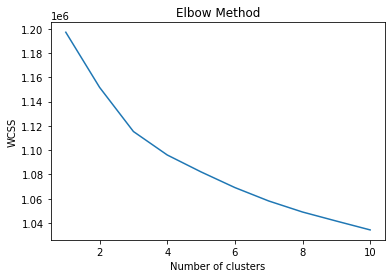

In [50]:
kmeans_elbow_method(w2vModel.wv.vectors.astype('double'))

From the above Elbow method plot is not easy to establish a definitive value of number of clusters. So, in order to be more precise, a Silhouette method could be usefull to undestand the right number of cluster.

In [51]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette(x,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(x)
        labels = km.predict(x)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :",
              silhouette_score(x, labels, metric='euclidean'))

In [52]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeans_silhouette(w2vModel.wv.vectors.astype('double'), rangeClusters)

The obtained value show that the clustering with n_clusters = 3 could perform better results.

## 4. Sentiment analysis with 3 clusters

The performed steps are the same of the previous analysis. The steps concerning Word2Vec, TF-IDF and TextBlob are not applied because the results would be the same with respect to the previous ones.

### 4.1 Clustering model

In [53]:
kmeansModel3Clusters = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50)
kmeansModel3Clusters.fit(X=w2vModel.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=3, n_init=50, random_state=42)

In [54]:
w2vModel.wv.similar_by_vector(
    kmeansModel3Clusters.cluster_centers_[2], topn=10, restrict_vocab=None)

[('shop', 0.7630400061607361),
 ('bahn', 0.7551607489585876),
 ('restaurant', 0.7389747500419617),
 ('bar', 0.7280189394950867),
 ('cafe', 0.7133153080940247),
 ('supermarket', 0.7072442173957825),
 ('nearby', 0.7017354965209961),
 ('tram', 0.6940931677818298),
 ('station', 0.6876291036605835),
 ('metro', 0.6812832951545715)]

In [55]:
negativeClusterIndex = 2
positiveClusterIndex = 0

In [56]:
dfWords3Clusters = pd.DataFrame(
    w2vModel.wv.key_to_index.keys())

dfWords3Clusters.columns = ['words']

dfWords3Clusters['vectors'] = \
    dfWords3Clusters['words'].apply(
        lambda x: w2vModel.wv[f'{x}'])

dfWords3Clusters['cluster'] = \
    dfWords3Clusters['vectors'].apply(
        lambda x: kmeansModel3Clusters.predict([np.array(x)]))

dfWords3Clusters.cluster = \
    dfWords3Clusters['cluster'].apply(
        lambda x: x[0])

dfWords3Clusters.head()

,words,vectors,cluster
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0
1,and,"[-0.15569599, -0.20120987, 0.14106072, -0.4791...",1
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",2
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",2
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0


In [57]:
dfWords3Clusters['cluster_value'] = \
    [-1 if i==negativeClusterIndex
     else 1 if i==positiveClusterIndex else 0
     for i in dfWords3Clusters['cluster']]

dfWords3Clusters['closeness_score'] = \
    dfWords3Clusters.apply(
        lambda x: 1/(kmeansModel3Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords3Clusters['sentiment_coeff'] = \
    dfWords3Clusters['closeness_score'] * \
    dfWords3Clusters['cluster_value']

dfWords3Clusters[
    dfWords3Clusters['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",2,-1,0.142319,-0.142319
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",2,-1,0.117026,-0.117026
7,of,"[0.47129914, -0.24029101, 0.18664457, -0.86250...",2,-1,0.102677,-0.102677
17,berlin,"[0.14385328, 0.4931988, 0.5186288, -0.27703884...",2,-1,0.097882,-0.097882
19,location,"[-0.15372258, 0.7725808, 0.6690001, 0.15646437...",2,-1,0.143531,-0.143531


### 4.2 Closeness score


In [58]:
dictSentiment3Clusters = dict(zip(
    dfWords3Clusters['words'].values,
    dfWords3Clusters['sentiment_coeff'].values))

In [59]:
closenessScores3Clusters = \
    dfCleanedReviews['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment3Clusters),
            x.split())))

### 4.3 Sentiment score computation

In [60]:
dfSentiment3ClustersTfidfReviews = pd.DataFrame(
    [closenessScores3Clusters,
     tfidfScores,
     dfCleanedReviews['comments']]).T

dfSentiment3ClustersTfidfReviews.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment3ClustersTfidfReviews['sentiment_rate'] = \
    dfSentiment3ClustersTfidfReviews.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment3ClustersTfidfReviews['prediction'] = \
    (dfSentiment3ClustersTfidfReviews['sentiment_rate']>0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.0, 0.1798011283274767, 0.0, 0.0, 0.0, 0.0, ...","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.873900,0
1,"[0.14073132621331927, 0.1798011283274767, 0.0,...","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-0.147324,0
2,"[0.0, 0.1447761464322067, 0.0, 0.0, 0.0, 0.135...","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,0.364683,1
3,"[0.0, -0.14353125369217165, -0.099881655919928...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-4.636182,0
4,"[0.0, 0.0, -0.0845358454151889, -0.10166596849...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-3.231733,0


In [61]:
# dfSentiment3ClustersTfidfReviews.to_csv(
#     'sentiment_dataset_3_clusters.csv',
#     sep=',', index=False, header=True)

In [62]:
dfNegativeSentiment = dfSentiment3ClustersTfidfReviews[
    dfSentiment3ClustersTfidfReviews['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

dfNegativeSentiment['review'].head().tolist()

['for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround by nice coffeeshops restaurant and bar they also give some really good tip to venture within the vicinity and further into berlin would recommend their place and their kindness for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround by nice coffeeshops restaurant and bar they also give some really good tip to venture within the vicinity and further into berlin would recommend their place and their kindness for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround

### 4.4 TextBlob


In [63]:
dfSentiment3ClustersTfidfReviews['textblob_sentiment'] = \
    textblobSentiment

dfSentiment3ClustersTfidfReviews['textblob_prediction'] = \
    (dfSentiment3ClustersTfidfReviews['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.0, 0.1798011283274767, 0.0, 0.0, 0.0, 0.0, ...","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.873900,0,0.617500,1
1,"[0.14073132621331927, 0.1798011283274767, 0.0,...","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-0.147324,0,0.800000,1
2,"[0.0, 0.1447761464322067, 0.0, 0.0, 0.0, 0.135...","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,0.364683,1,0.561250,1
3,"[0.0, -0.14353125369217165, -0.099881655919928...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-4.636182,0,0.643750,1
4,"[0.0, 0.0, -0.0845358454151889, -0.10166596849...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-3.231733,0,0.226042,1


### 4.5 Sentiment analysis evaluation

In [64]:
testScores3ClustersSentiment = compute_test_scores(
    dfSentiment3ClustersTfidfReviews['prediction'],
    dfSentiment3ClustersTfidfReviews['textblob_prediction'])

dfTestScores3ClustersSentiment = pd.DataFrame([testScores3ClustersSentiment])
dfTestScores3ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores3ClustersSentiment = dfTestScores3ClustersSentiment.T
dfTestScores3ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 3 clusters and no stopwords: ')
dfTestScores3ClustersSentiment

       0       1
0    947    2976
1  85726  169118
Scores for sentiment analysis with 3 clusters and no stopwords: 


,scores
accuracy,0.657213
precision,0.982707
recall,0.663614
f1,0.792237


The sentiment anlysis with 3 clusters show better results compared to the sentiment analysis with 2 clusters.
However could be interesting to investigate the results that can be obtained by removing the stop words. 

## 5. Sentiment Analysis without stop words

The performed steps are the same as before.

### 5.1 Stop words removal

In order to remove the stop words, the 'stopwords' package of the 'nltk' library is used.

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
from nltk.corpus import stopwords

stopWords = stopwords.words('english')
stopWords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [67]:
def remove_stop_words(tokenized_reviews, stop_words):
    tokenized_reviews_without_stopwords = []
    for tokenized_review in tokenized_reviews:
        tokenized_reviews_without_stopwords.append(
            [word for word in tokenized_review if not word in stop_words]
        )
    return tokenized_reviews_without_stopwords

In [68]:
lemmatizedTokenizedEnglishReviewsWithoutStopWords = remove_stop_words(
    lemmatizedTokenizedEnglishReviews, stopWords)
lemmatizedTokenizedEnglishReviewsWithoutStopWords[:5]

[['jan',
  'friendly',
  'welcome',
  'host',
  'apartment',
  'great',
  'area',
  'sooo',
  'amaze',
  'lot',
  'nice',
  'cafe',
  'shop',
  'enjoy',
  'time',
  'lot'],
 ['really', 'nice', 'area', 'food', 'park', 'transport', 'perfect'],
 ['nice',
  'stay',
  'berlin',
  'thanks',
  'jan',
  'premium',
  'situate',
  'apartment',
  'place',
  'big',
  'quiet',
  'functional',
  'also',
  'situate',
  'perfect',
  'neighbourhood',
  'jan',
  'welcome',
  'host',
  'eager',
  'help',
  'need',
  'provide',
  'kind',
  'information',
  'also',
  'good',
  'advice',
  'biergarten'],
 ['great',
  'location',
  'close',
  'mauerpark',
  'kastanienallee',
  'rosenthaler',
  'platz',
  'lot',
  'bar',
  'restaurant',
  'nearby',
  'jan',
  'friendly',
  'service',
  'mind'],
 ['apartment',
  'well',
  'locate',
  'close',
  'everything',
  'supermarket',
  'transport',
  'city',
  'center',
  'quiet',
  'night',
  'apartment',
  'locate',
  'inside',
  'building',
  'basic',
  'equipment',

### 5.2 Bigrams generation

In [69]:
phrasesWithoutStopWords = Phrases(lemmatizedTokenizedEnglishReviewsWithoutStopWords,
                                  min_count=3,
                                  progress_per=50000)

bigramWithoutStopWords = Phraser(phrasesWithoutStopWords)

bigramReviewsWithoutStopWords = bigramWithoutStopWords[
    lemmatizedTokenizedEnglishReviewsWithoutStopWords]

bigramReviewsWithoutStopWords[0]

['jan',
 'friendly',
 'welcome',
 'host',
 'apartment',
 'great',
 'area',
 'sooo',
 'amaze',
 'lot',
 'nice',
 'cafe',
 'shop',
 'enjoy',
 'time',
 'lot']

In [70]:
dictWordFreq = defaultdict(int)
for review in bigramReviewsWithoutStopWords:
    for i in review:
        dictWordFreq[i] += 1

len(dictWordFreq)

64487

In [71]:
sorted(dictWordFreq, key=dictWordFreq.get, reverse=True)[:10]

['great',
 'apartment',
 'stay',
 'place',
 'berlin',
 'nice',
 'location',
 'host',
 'clean',
 'good']

### 5.3 Word2Vec model

In [72]:
if os.path.exists('word2vec_no_stopwords.model'):
    w2vModelWithoutStopWords = Word2Vec.load('word2vec_no_stopwords.model')
else:
    w2vModelWithoutStopWords = Word2Vec(min_count=20,
                                 window=4,
                                 vector_size=300,
                                 sample=6e-5,
                                 alpha=0.03,
                                 min_alpha=0.0007,
                                 negative=20,
                                 workers=4)

    t = time()
    w2vModelWithoutStopWords.build_vocab(bigramReviewsWithoutStopWords, progress_per=10000)
    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

    t = time()
    w2vModelWithoutStopWords.train(bigramReviewsWithoutStopWords,
                                   total_examples=w2vModelWithoutStopWords.corpus_count,
                                   epochs=30,
                                   report_delay=1)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

    w2vModelWithoutStopWords.save("word2vec_no_stopwords.model")

In [73]:
w2vModelWithoutStopWords.wv.most_similar(positive=["apartment"])

[('flat', 0.6878382563591003),
 ('spacious', 0.4964258074760437),
 ('modern', 0.48108017444610596),
 ('studio', 0.4650469124317169),
 ('clean', 0.4501889944076538),
 ('comfortably_furnish', 0.38306912779808044),
 ('building', 0.3798222839832306),
 ('bright', 0.377280056476593),
 ('modern_furnishing', 0.37452903389930725),
 ('beautifully_appoint', 0.37319716811180115)]

### 5.4 Clustering model

In [74]:
kmeansModel2Clusters = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeansModel2Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [75]:
w2vModelWithoutStopWords.wv.similar_by_vector(kmeansModel2Clusters.cluster_centers_[0],
                                              topn=10,
                                              restrict_vocab=None)

[('due_lack', 0.6634340882301331),
 ('wire', 0.660079300403595),
 ('useless', 0.636574387550354),
 ('unacceptable', 0.6353410482406616),
 ('rug', 0.6306374073028564),
 ('take_trash', 0.6300591826438904),
 ('filthy', 0.6290209293365479),
 ('leak', 0.6218292117118835),
 ('trap', 0.6210276484489441),
 ('smelly', 0.6185833811759949)]

In [76]:
negativeClusterIndex = 0

In [77]:
dfWords2ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords2ClustersWithoutStopWords.columns = ['words']

dfWords2ClustersWithoutStopWords['vectors'] = \
    dfWords2ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['vectors'].apply(
        lambda x: kmeansModel2Clusters.predict([np.array(x)]))

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords2ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.021736015, -0.09696648, -0.20334733, 0.3184...",1
1,apartment,"[0.09413033, -0.20562932, -0.09986646, -0.0815...",1
2,stay,"[-0.04194155, 0.27263644, -0.30879694, -0.4886...",1
3,place,"[0.1171688, -0.45740342, -0.18468466, 0.219762...",1
4,berlin,"[-0.062057998, 0.043246496, -0.19278, -0.67646...",1


In [78]:
dfWords2ClustersWithoutStopWords['cluster_value'] = [
    -1 if i==negativeClusterIndex else 1
    for i in dfWords2ClustersWithoutStopWords['cluster']]

dfWords2ClustersWithoutStopWords['closeness_score'] = \
    dfWords2ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel2Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords2ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords2ClustersWithoutStopWords['closeness_score'] * \
    dfWords2ClustersWithoutStopWords['cluster_value']

dfWords2ClustersWithoutStopWords[
    dfWords2ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.1289804, -0.47577977, 0.45509025, 0.071285...",0,-1,0.135719,-0.135719
18,comfortable,"[-0.105109595, -0.28582796, 0.23227535, -0.098...",0,-1,0.139571,-0.139571
40,like,"[0.2838839, -0.5819455, 0.27681106, -0.0084737...",0,-1,0.132852,-0.132852
45,one,"[-0.7768008, -0.64739054, 0.637206, -0.629718,...",0,-1,0.162380,-0.162380
46,bed,"[-0.37433314, -0.19291034, 0.44292012, -0.3003...",0,-1,0.107758,-0.107758


### 5.5 TF-IDF

In [79]:
dfCleanedReviewsWithoutStopWords = pd.DataFrame(
    [' '.join(review) for review in lemmatizedTokenizedEnglishReviewsWithoutStopWords],
    columns=['comments'])

dfCleanedReviewsWithoutStopWords.head()

,comments
0,jan friendly welcome host apartment great area...
1,really nice area food park transport perfect
2,nice stay berlin thanks jan premium situate ap...
3,great location close mauerpark kastanienallee ...
4,apartment well locate close everything superma...


In [80]:
tfidfWithoutStopWords = TfidfVectorizer(norm=None)
transformed = tfidfWithoutStopWords.fit_transform(
    dfCleanedReviewsWithoutStopWords['comments'].tolist())
features = pd.Series(tfidfWithoutStopWords.get_feature_names())

In [81]:
tfidfScoresWithoutStopWords = dfCleanedReviewsWithoutStopWords.apply(
    lambda x: replace_tfidf_words(x, transformed, features), axis=1)

### 5.6 Closeness score

In [82]:
dictSentiment2ClustersWithoutStopWords = dict(zip(
    dfWords2ClustersWithoutStopWords['words'].values,
    dfWords2ClustersWithoutStopWords['sentiment_coeff'].values))

In [83]:
closenessScores2ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment2ClustersWithoutStopWords),
            x.split())))

### 5.7 Sentiment score computation

In [84]:
dfSentiment2ClustersTfidfReviewsWithoutStopWords = \
    pd.DataFrame([closenessScores2ClustersWithoutStopWords,
                  tfidfScoresWithoutStopWords,
                  dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment2ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment2ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] =\
    (dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.08274272026931886, 0.14438650901133268, 0.1...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,8.102213,1
1,"[0.21196840433660452, 0.17771365086007282, 0.1...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,2.926502,1
2,"[0.17771365086007282, 0.17679454909616302, 0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,15.925815,1
3,"[0.2001186764725056, 0.16337263418936798, 0.10...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.887016,1
4,"[0.18721176816409277, 0.1347721306573096, 0.11...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,5.763220,1


In [85]:
dfNegativeSentiment = dfSentiment2ClustersTfidfReviewsWithoutStopWords[
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

print('Top-5 negative reviews:')
dfNegativeSentiment['review'].head().tolist()

Top-5 negative reviews:


['big flat heart neuk lln min station nice flatmate amazing room day everything fine flat mate nice reccomend every website hide airbnb sure like thanks benjamin sonia luca website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb',
 'one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like g

In [86]:
# dfSentiment2ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_2_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

### 5.8 TextBlob

In [87]:
textblobSentimentWithoutStopWords = dfCleanedReviewsWithoutStopWords['comments'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

textblobSentimentWithoutStopWords.head()

0    0.595000
1    0.800000
2    0.487500
3    0.587500
4    0.229762
Name: comments, dtype: float64

In [88]:
dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] = \
    textblobSentimentWithoutStopWords

dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_prediction'] = \
    (dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.08274272026931886, 0.14438650901133268, 0.1...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,8.102213,1,0.595000,1
1,"[0.21196840433660452, 0.17771365086007282, 0.1...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,2.926502,1,0.800000,1
2,"[0.17771365086007282, 0.17679454909616302, 0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,15.925815,1,0.487500,1
3,"[0.2001186764725056, 0.16337263418936798, 0.10...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.887016,1,0.587500,1
4,"[0.18721176816409277, 0.1347721306573096, 0.11...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,5.763220,1,0.229762,1


### 5.9 Sentiment analysis evaluation

In [89]:
testScores2ClustersWithoutStopWordsSentiment = compute_test_scores(
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_prediction'])

dfTestScores2ClustersWithoutStopWordsSentiment = pd.DataFrame(
    [testScores2ClustersWithoutStopWordsSentiment])

dfTestScores2ClustersWithoutStopWordsSentiment.columns = \
    ['accuracy', 'precision', 'recall', 'f1']

dfTestScores2ClustersWithoutStopWordsSentiment = \
    dfTestScores2ClustersWithoutStopWordsSentiment.T

dfTestScores2ClustersWithoutStopWordsSentiment.columns = ['scores']

print('Scores for sentiment analysis with 2 clusters and no stopwords: ')
dfTestScores2ClustersWithoutStopWordsSentiment

       0       1
0   1425    3100
1  13517  240725
Scores for sentiment analysis with 2 clusters and no stopwords: 


,scores
accuracy,0.935784
precision,0.987286
recall,0.946834
f1,0.966637


The obtained results seem to be very good. Even in this case it is possible to check whether there exists a better value for the number of cluster.

### 5.10 Clustering evaluation

inertia_ 1019374.8914507161
inertia_ 979036.4512069453
inertia_ 945731.9965046742
inertia_ 928825.8544302889
inertia_ 916296.311814165
inertia_ 903468.412742547
inertia_ 893577.2260768566
inertia_ 886675.7141103031
inertia_ 879206.5099118422
inertia_ 872744.2123647004


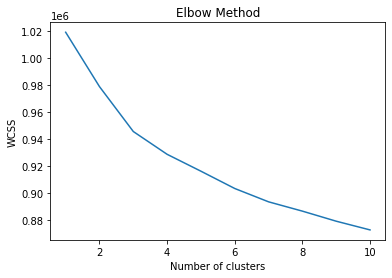

In [90]:
kmeans_elbow_method(w2vModelWithoutStopWords.wv.vectors.astype('double'))

In [91]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeans_silhouette(w2vModelWithoutStopWords.wv.vectors.astype('double'), rangeClusters)

For n_clusters = 2 The computed average silhouette_score is : 0.06882298045419695
For n_clusters = 3 The computed average silhouette_score is : 0.05184578923038232
For n_clusters = 4 The computed average silhouette_score is : 0.0489808665742103
For n_clusters = 5 The computed average silhouette_score is : 0.004672535626036191
For n_clusters = 6 The computed average silhouette_score is : -0.0008970731786193938
For n_clusters = 7 The computed average silhouette_score is : -0.007605956063358059
For n_clusters = 8 The computed average silhouette_score is : -0.04694576278840496
For n_clusters = 9 The computed average silhouette_score is : -0.04297953670725326
For n_clusters = 10 The computed average silhouette_score is : -0.04051978810825676


Even if the Silhouette method shows a worse score with n_clusters = 3 it can be intersting to check how much the model accuracy changes.

## 6. Sentiment analysis without stop words with 3 clusters

The performed steps are the same as before.

### 6.1 Clustering model

In [92]:
kmeansModel3Clusters = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50)
kmeansModel3Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=3, n_init=50, random_state=42)

In [93]:
w2vModelWithoutStopWords.wv.similar_by_vector(
    kmeansModel3Clusters.cluster_centers_[2], topn=10, restrict_vocab=None)

[('wire', 0.6604833006858826),
 ('due_lack', 0.6506068110466003),
 ('rug', 0.6456260085105896),
 ('useless', 0.6366190314292908),
 ('filthy', 0.6263508796691895),
 ('smelly', 0.6249639987945557),
 ('bathroom', 0.6226907968521118),
 ('leak', 0.6207293272018433),
 ('unacceptable', 0.6182073950767517),
 ('tape', 0.6162527203559875)]

In [94]:
negativeClusterIndex = 2
positiveClusterIndex = 0

In [95]:
dfWords3ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords3ClustersWithoutStopWords.columns = ['words']

dfWords3ClustersWithoutStopWords['vectors'] = \
    dfWords3ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords3ClustersWithoutStopWords['cluster'] = \
    dfWords3ClustersWithoutStopWords['vectors'].apply(
        lambda x: kmeansModel3Clusters.predict([np.array(x)]))

dfWords3ClustersWithoutStopWords.cluster = \
    dfWords3ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords3ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.021736015, -0.09696648, -0.20334733, 0.3184...",1
1,apartment,"[0.09413033, -0.20562932, -0.09986646, -0.0815...",1
2,stay,"[-0.04194155, 0.27263644, -0.30879694, -0.4886...",1
3,place,"[0.1171688, -0.45740342, -0.18468466, 0.219762...",1
4,berlin,"[-0.062057998, 0.043246496, -0.19278, -0.67646...",0


In [96]:
dfWords3ClustersWithoutStopWords['cluster_value'] = \
    [-1 if i==negativeClusterIndex
     else 1 if i==positiveClusterIndex else 0
     for i in dfWords3ClustersWithoutStopWords['cluster']]

dfWords3ClustersWithoutStopWords['closeness_score'] = \
    dfWords3ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel3Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords3ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords3ClustersWithoutStopWords['closeness_score'] * \
    dfWords3ClustersWithoutStopWords['cluster_value']

dfWords3ClustersWithoutStopWords[
    dfWords3ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.1289804, -0.47577977, 0.45509025, 0.071285...",2,-1,0.137974,-0.137974
18,comfortable,"[-0.105109595, -0.28582796, 0.23227535, -0.098...",2,-1,0.142628,-0.142628
40,like,"[0.2838839, -0.5819455, 0.27681106, -0.0084737...",2,-1,0.133966,-0.133966
45,one,"[-0.7768008, -0.64739054, 0.637206, -0.629718,...",2,-1,0.161954,-0.161954
46,bed,"[-0.37433314, -0.19291034, 0.44292012, -0.3003...",2,-1,0.109352,-0.109352


### 6.2 Closeness score

In [97]:
dictSentiment3ClustersWithoutStopWords = dict(zip(
    dfWords3ClustersWithoutStopWords['words'].values,
    dfWords3ClustersWithoutStopWords['sentiment_coeff'].values))

In [98]:
closenessScores3ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment3ClustersWithoutStopWords),
            x.split())))

### 6.3 Sentiment score computation

In [99]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords = pd.DataFrame(
    [closenessScores3ClustersWithoutStopWords,
     tfidfScoresWithoutStopWords,
     dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment3ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment3ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate']>0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1530401787107...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.171116,1
1,"[0.0, 0.0, 0.1530401787107593, 0.0962295034379...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.725799,1
2,"[0.0, 0.0, 0.1417771922395551, 0.0, 0.0, -0.14...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.913388,1
3,"[0.0, 0.1948514168094835, 0.14606870725559232,...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,3.140077,1
4,"[0.0, 0.12948971833364556, 0.14316824211234594...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.336270,1


In [100]:
# dfSentiment3ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_3_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

In [101]:
dfNegativeSentiment = dfSentiment3ClustersTfidfReviewsWithoutStopWords[
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

dfNegativeSentiment['review'].head().tolist()

['one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like good idea terrible problem lend pet stranger felt like short story bring two cat apartment dealt immediate emergency mouse run around tell cat ingenious idea okay untenable situation handle mouse cat one cat actually actively go mouse cat well behave pleasant mean need care get fee incessant nudging feed vacation benjamin home rental apartment business fair mouse feces remain unabated benjamin evidently come apartment without knowledge except alert us bring exterminator exterminator say apparently entire building contaminate mouse set poison traps host exterminator discuss mouse entry point observed location mouse droppings throughout apartment dis

### 6.4 TextBlob

In [102]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] = \
    textblobSentimentWithoutStopWords

dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1530401787107...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.171116,1,0.595000,1
1,"[0.0, 0.0, 0.1530401787107593, 0.0962295034379...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.725799,1,0.800000,1
2,"[0.0, 0.0, 0.1417771922395551, 0.0, 0.0, -0.14...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.913388,1,0.487500,1
3,"[0.0, 0.1948514168094835, 0.14606870725559232,...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,3.140077,1,0.587500,1
4,"[0.0, 0.12948971833364556, 0.14316824211234594...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.336270,1,0.229762,1


### 6.5 Sentiment analysis evaluation

In [103]:
testScores3ClustersWithoutStopWordsSentiment = compute_test_scores(
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_prediction'])

dfTestScores3ClustersWithoutStopWordsSentiment = pd.DataFrame(
    [testScores3ClustersWithoutStopWordsSentiment])

dfTestScores3ClustersWithoutStopWordsSentiment.columns = \
    ['accuracy', 'precision', 'recall', 'f1']

dfTestScores3ClustersWithoutStopWordsSentiment = \
    dfTestScores3ClustersWithoutStopWordsSentiment.T

dfTestScores3ClustersWithoutStopWordsSentiment.columns = ['scores']

print('Scores for sentiment analysis with 3 clusters and no stopwords: ')
dfTestScores3ClustersWithoutStopWordsSentiment


        0       1
0    3263    1262
1  108395  145847
Scores for sentiment analysis with 3 clusters and no stopwords: 


,scores
accuracy,0.576233
precision,0.991421
recall,0.573654
f1,0.726780


The obtained results are strongly worse with respect to the ones that could be expected. It was reasonable to expect a decrease in the accuracy score but not so marked.